**“Red Wine Quality Prediction”**

Data Analytics - Project

Kacper Błachowiak, Jakub Ciura

1. Problem formulation

- Project Goal

The project goal is to predict quality of variants of the Portuguese "Vinho Verde".
Prediction will be based on values of selected input variables such as: fixed acidity,
volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur
dioxide, density, pH, sulphates, alcohol. As a result system will determine quality of wine
and classify each to appropriate category (poor, excellent, etc.)

- Purpose of Creating a Model and Potential Use Cases

The main goal of building a model using this dataset is to predict the quality of red wine based on its physicochemical properties. By analyzing these features, a predictive model can help estimate the wine quality score without the need for costly and time-consuming expert tastings.

Potential use cases include:

  -  Assisting winemakers in quality control by identifying batches with likely high or low quality before distribution.

- Supporting decisions in blending and production processes to improve overall wine quality.

- Enabling retailers and consumers to better understand and evaluate wine quality through data-driven insights.

- Serving as a benchmark for developing more advanced machine learning models in food and beverage quality assessment.

- Source of the data and contents

The data comes from a public dataset available on Kaggle, based on research published by Cortez et al. in 2009. This dataset was created to analyze the quality of red wine based on various physicochemical properties.

It contains 1,599 samples of red wine, each described by 11 physicochemical features such as fixed acidity, volatile acidity, residual sugar, pH, sulfur dioxide levels, and alcohol content. Each sample is also assigned a quality score ranging from 0 to 10, given by expert tasters. The goal of this dataset is to enable analysis and modeling of the relationship between the chemical characteristics and the wine quality rating.

- DAG

/tmp/ipykernel_9/2580940403.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


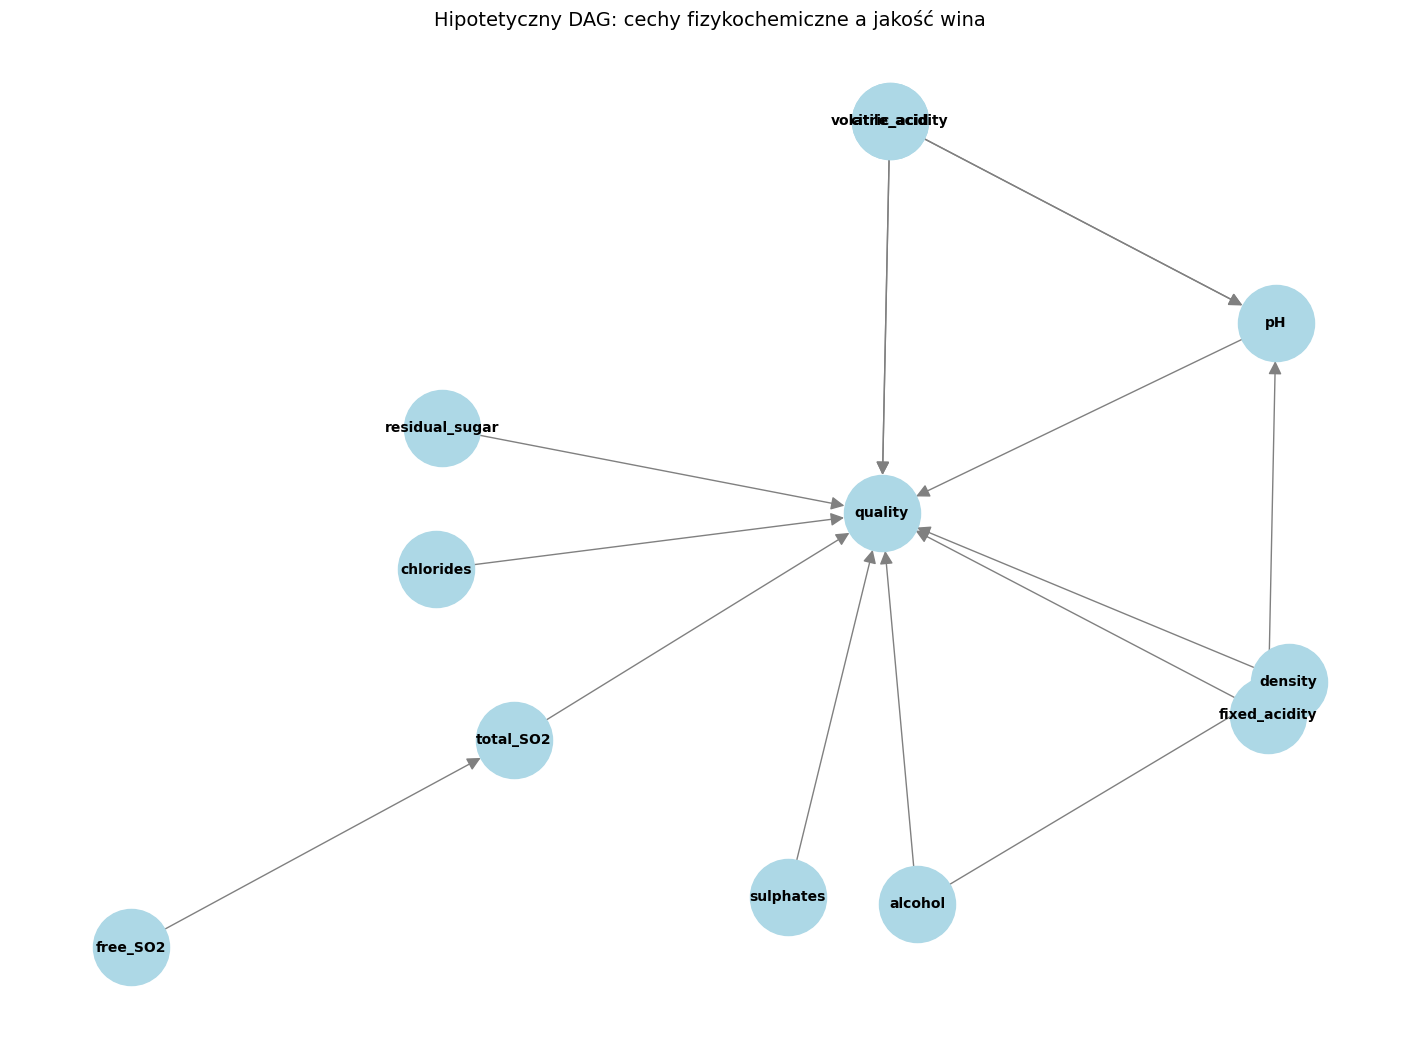

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. Tworzenie grafu DAG
G = nx.DiGraph()

edges = [
    ('fixed_acidity', 'pH'),
    ('volatile_acidity', 'pH'),
    ('citric_acid', 'pH'),
    ('citric_acid', 'quality'),
    ('residual_sugar', 'quality'),
    ('pH', 'quality'),
    ('chlorides', 'quality'),
    ('free_SO2', 'total_SO2'),
    ('total_SO2', 'quality'),
    ('sulphates', 'quality'),
    ('alcohol', 'quality'),
    ('alcohol', 'density'),
    ('density', 'quality'),
    ('fixed_acidity', 'quality'),
    ('volatile_acidity', 'quality'),
]

G.add_edges_from(edges)

# 2. Ustawienie layoutu
pos = nx.kamada_kawai_layout(G)  # Możesz też spróbować nx.spring_layout(G, k=1.5)

# 3. Rysowanie
plt.figure(figsize=(14, 10))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    node_size=3000,
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    arrowsize=20
)
plt.title("Hipotetyczny DAG: cechy fizykochemiczne a jakość wina", fontsize=14)
plt.tight_layout()
plt.show()


- confoundings (pipe, fork, collider) were described
  
| Fork                                  | Opis                                    |

| ------------------------------------- | --------------------------------------- |

| `citric_acid ← pH → volatile_acidity` | pH jest wspólną przyczyną dwóch cech    |

| `pH ← fixed_acidity → quality`        | fixed\_acidity wpływa na pH i na jakość |

| `pH ← volatile_acidity → quality`     | volatile\_acidity wpływa na pH i jakość |

| `density ← alcohol → quality`         | alkohol wpływa na gęstość i jakość      |

| Pipe                              | Opis                                           |

| --------------------------------- | ---------------------------------------------- |

| `citric_acid → pH → quality`      | pośredni wpływ cytrynowego kwasu na jakość     |

| `fixed_acidity → pH → quality`    | pH jest ogniwem między kwasowością a jakością  |

| `volatile_acidity → pH → quality` | lotna kwasowość przez pH wpływa na jakość      |

| `free_SO2 → total_SO2 → quality`  | suma SO₂ pośredniczy w wpływie wolnego SO₂     |

| `alcohol → density → quality`     | gęstość jest ogniwem wpływu alkoholu na jakość |

| Collider                                   | Opis                       |

| ------------------------------------------ | -------------------------- |

| `citric_acid → quality ← fixed_acidity`    | jakość jako wspólny skutek |

| `citric_acid → quality ← volatile_acidity` |                            |

| `residual_sugar → quality ← pH`            |                            |

| `chlorides → quality ← pH`                 |                            |

| `total_SO2 → quality ← sulphates`          |                            |

| `alcohol → quality ← sulphates`            |                            |

| `density → quality ← alcohol`              |                            |

| `density → quality ← pH`                   |                            |




2. Data preprocessing <-- need to be specified and reasoned

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Descriptive statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000    

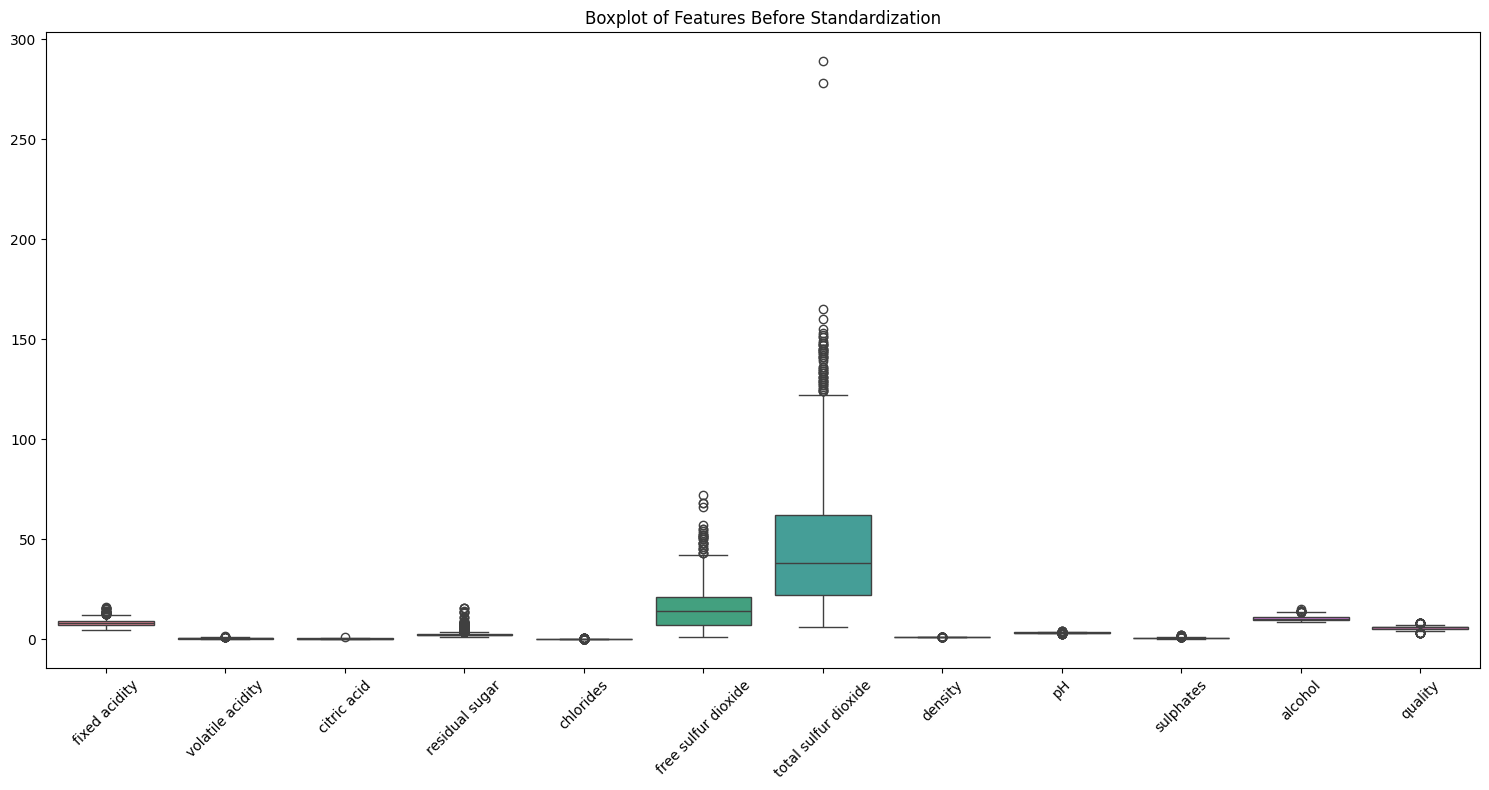

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv("projekt/data/winequality-red.csv")

# --- 1. Sprawdzenie braków danych ---
print("Missing values per column:")
print(df.isnull().sum())

# --- 2. Statystyki opisowe ---
print("\nDescriptive statistics:")
print(df.describe())

# --- 3. Wykrywanie outlierów (np. za pomocą z-score) ---
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)

print("\nNumber of outliers per column (|z| > 3):")
print(outliers)

# Opcjonalnie: wizualizacja boxplotami
plt.figure(figsize=(15, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Features Before Standardization")
plt.tight_layout()
plt.show()

# --- 4. Standaryzacja danych ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop("quality", axis=1))

X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1])
y = df["quality"]

All of samples are fully described (all columns filled)

Outlier analysis indicated that several features (e.g., total sulfur dioxide, residual sugar) contain extreme values based on z-score > 3. However, these values were retained, as they fall within chemically plausible ranges and reflect naturally occurring variation in wine production practices.


Checking the correlation of predictors

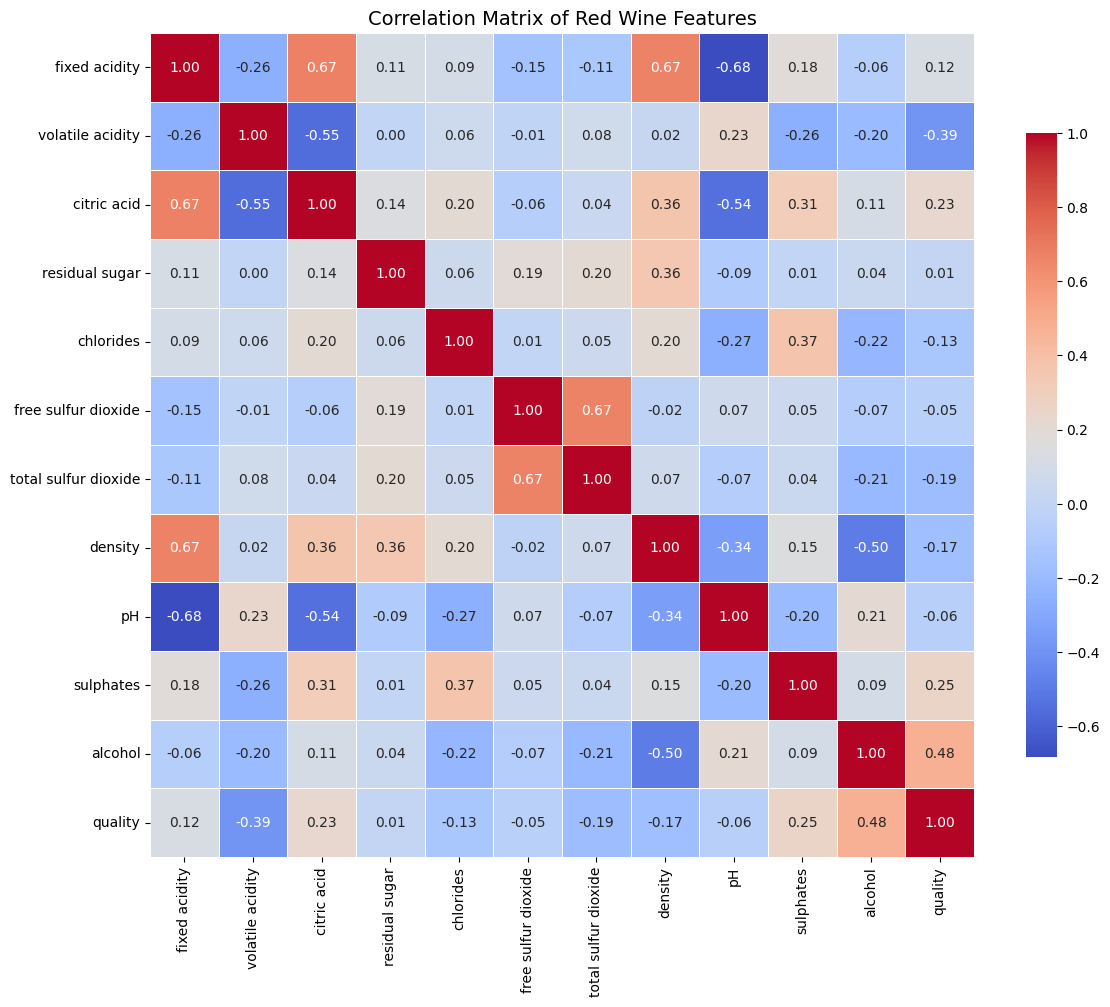

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór tylko zmiennych liczbowych
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Obliczenie macierzy korelacji (Pearson)
correlation_matrix = numeric_features.corr(method='pearson')

# Wizualizacja
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .75}
)
plt.title("Correlation Matrix of Red Wine Features", fontsize=14)
plt.tight_layout()
plt.show()


Conclusions^

Great correlation with target (quality):
- alcohol	+0.48	najsilniejsza pozytywna korelacja – warto uwzględnić
- volatile acidity	-0.39	dość silna negatywna korelacja – warto uwzględnić
- sulphates	+0.25	umiarkowana korelacja – można uwzględnić
- citric acid	+0.23	umiarkowana – można rozważyć
- density	-0.17	słaba korelacja – ale może być problem kolinearności

High correlation between features:
- density vs residual sugar: +0.36
- fixed acidity vs citric acid: +0.67
- total sulfur dioxide vs free sulfur dioxide: +0.67
- density vs fixed acidity: +0.67
- pH vs fixed acidity: -0.68


Due to above, **basic model** consists of predictors: alcohol, volatile acidity and sulphates.

Additionally, it **second version of model** may be extended with citric acid and density.


Train-test split

In [13]:
"""# --- 5. Podział na zbiór treningowy i testowy ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")"""


'# --- 5. Podział na zbiór treningowy i testowy ---\nX_train, X_test, y_train, y_test = train_test_split(\n    X_scaled_df, y, test_size=0.2, random_state=42\n)\n\nprint(f"\nTraining samples: {X_train.shape[0]}")\nprint(f"Test samples: {X_test.shape[0]}")'

**3. Models**

Creating data, which consists of predictors: *alcohol, volatile acidity, sulphates*.

In [16]:
# Wybrane predyktory do modelu 1
selected_predictors = ["alcohol", "volatile acidity", "sulphates"]

# Standaryzacja tylko wybranych predyktorów
X_selected = df[selected_predictors].values
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

# Target
y = df["quality"].values

# Struktura danych dla Stan
stan_data = {
    "N": X_scaled_selected.shape[0],
    "K": X_scaled_selected.shape[1],
    "X": X_scaled_selected,
    "y": y
}


In [ ]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_1.stan")

fit = model.sample(
    data=stan_data,  # przygotowana wcześniej struktura
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

12:32:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:32:50 - cmdstanpy - INFO - CmdStan done processing.
12:32:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model1.stan', line 21, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -149.552000  0.035591  1.625450  1.362510 -152.651000 -149.211000   
alpha      5.634760  0.000219  0.016153  0.016234    5.607760    5.634440   
beta[1]    0.329718  0.000247  0.017049  0.016678    0.302018    0.329353   
beta[2]   -0.218305  0.000234  0.017192  0.017493   -0.246067   -0.218465   
beta[3]    0.115372  0.000251  0.017364  0.017184    0.086910    0.115791   
sigma      0.659239  0.000177  0.011728  0.011830    0.640441    0.658967   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__    -147.658000   2124.34   2849.45  1.000490  
alpha      5.661100   5512.44   2915.41  1.000030  
beta[1]    0.358415   4811.74   2995.33  0.999506  
beta[2]   -0.190033   5469.13   3350.82  1.000790  
beta[3]    0.143843   4899.73   2840.29  1.001140  
sigma      0.678742   4444.29   2832.08  1.003690  


**Prior predictive check - model 1**

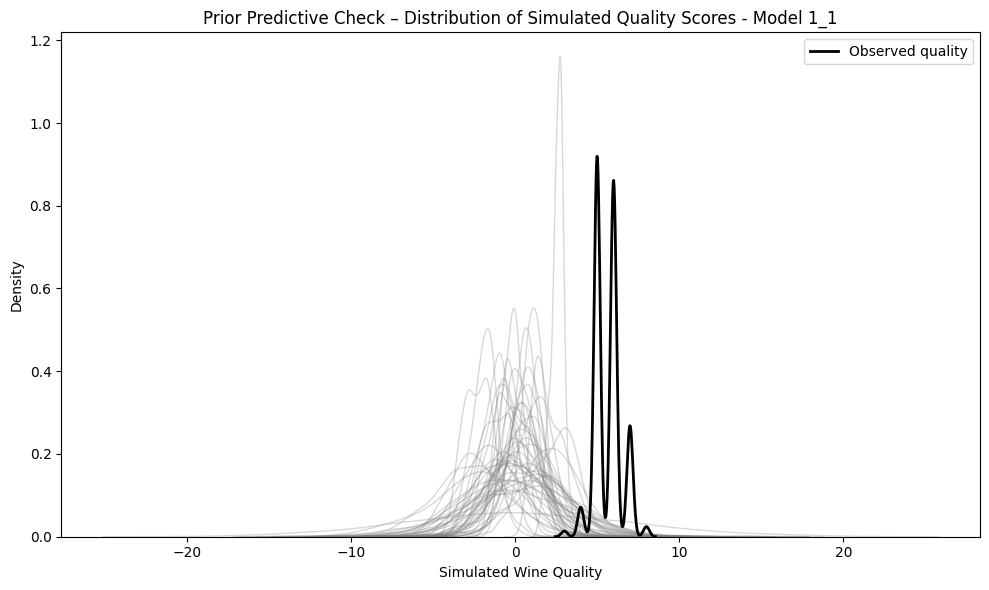

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
n_samples = 500  # ile razy losujemy alpha, beta, sigma
n_obs = X_scaled_selected.shape[0]  # liczba obserwacji

# Wygeneruj próbki z PRIÓRÓW
alpha_prior = np.random.normal(loc=0, scale=1, size=n_samples)
beta_prior = np.random.normal(loc=0, scale=1, size=(n_samples, 3))  # 3 predyktory
sigma_prior = np.random.exponential(scale=1.0, size=n_samples)

# Prior predictive simulations
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Konwersja
y_prior_samples = np.array(y_prior_samples)

# Wykres – kilka przykładowych krzywych
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

# Rzeczywisty rozkład jakości dla porównania
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Prior Predictive Check – Distribution of Simulated Quality Scores - Model 1_1")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


We can see, that simulated quality scores doesn't make sense - should be between 3 to 8. Let's create a new version of model: *model1_2.stan*

In [24]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_2.stan")

fit = model.sample(
    data=stan_data,  # przygotowana wcześniej struktura
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

12:53:24 - cmdstanpy - INFO - compiling stan file /workspace/projekt/models/model1_2.stan to exe file /workspace/projekt/models/model1_2
12:53:43 - cmdstanpy - INFO - compiled model executable: /workspace/projekt/models/model1_2
12:53:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:53:44 - cmdstanpy - INFO - CmdStan done processing.
12:53:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



             Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__    -2.479080  0.044395  1.673210  1.497540 -5.737960 -2.137430 -0.433986   
alpha    5.503520  0.015905  1.005690  1.020730  3.855590  5.509620  7.161210   
beta[1] -0.001129  0.007865  0.493870  0.496750 -0.798055 -0.007143  0.817549   
beta[2] -0.002161  0.007974  0.491185  0.495737 -0.811438 -0.000422  0.813447   
beta[3] -0.006525  0.008947  0.515472  0.509632 -0.860668 -0.002643  0.834715   
sigma    0.796666  0.010945  0.607579  0.604405  0.051547  0.673546  1.984840   

         ESS_bulk  ESS_tail    R_hat  
lp__      1470.03   2235.43  1.00120  
alpha     4007.16   2594.43  1.00172  
beta[1]   3949.20   2814.48  1.00053  
beta[2]   3794.10   2692.69  1.00263  
beta[3]   3370.46   2692.59  1.00054  
sigma     1943.20   1248.02  1.00374  


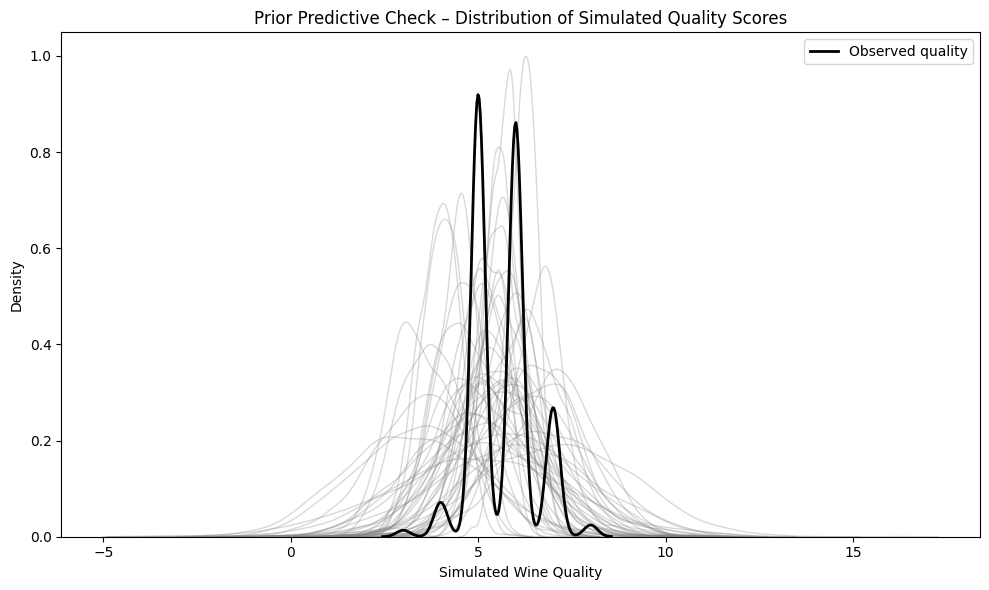

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
n_samples = 500  # ile razy losujemy alpha, beta, sigma
n_obs = X_scaled_selected.shape[0]  # liczba obserwacji

# Wygeneruj próbki z PRIÓRÓW
alpha_prior = np.random.normal(loc=5.5, scale=1.0, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=0.5, size=(n_samples, 3))
sigma_prior = np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_samples))  # T[0,]

# Prior predictive simulations
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Konwersja
y_prior_samples = np.array(y_prior_samples)

# Wykres – kilka przykładowych krzywych
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

# Rzeczywisty rozkład jakości dla porównania
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Posterior Distributions – Model 1")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

After adjusting our priors to be more informative (centered around expected quality levels and with reduced variance), the prior predictive check showed that the simulated data aligns well with the observed range of wine quality (mostly between 3 and 8). This confirms that our prior beliefs do not produce implausible outputs and are suitable for further posterior inference.

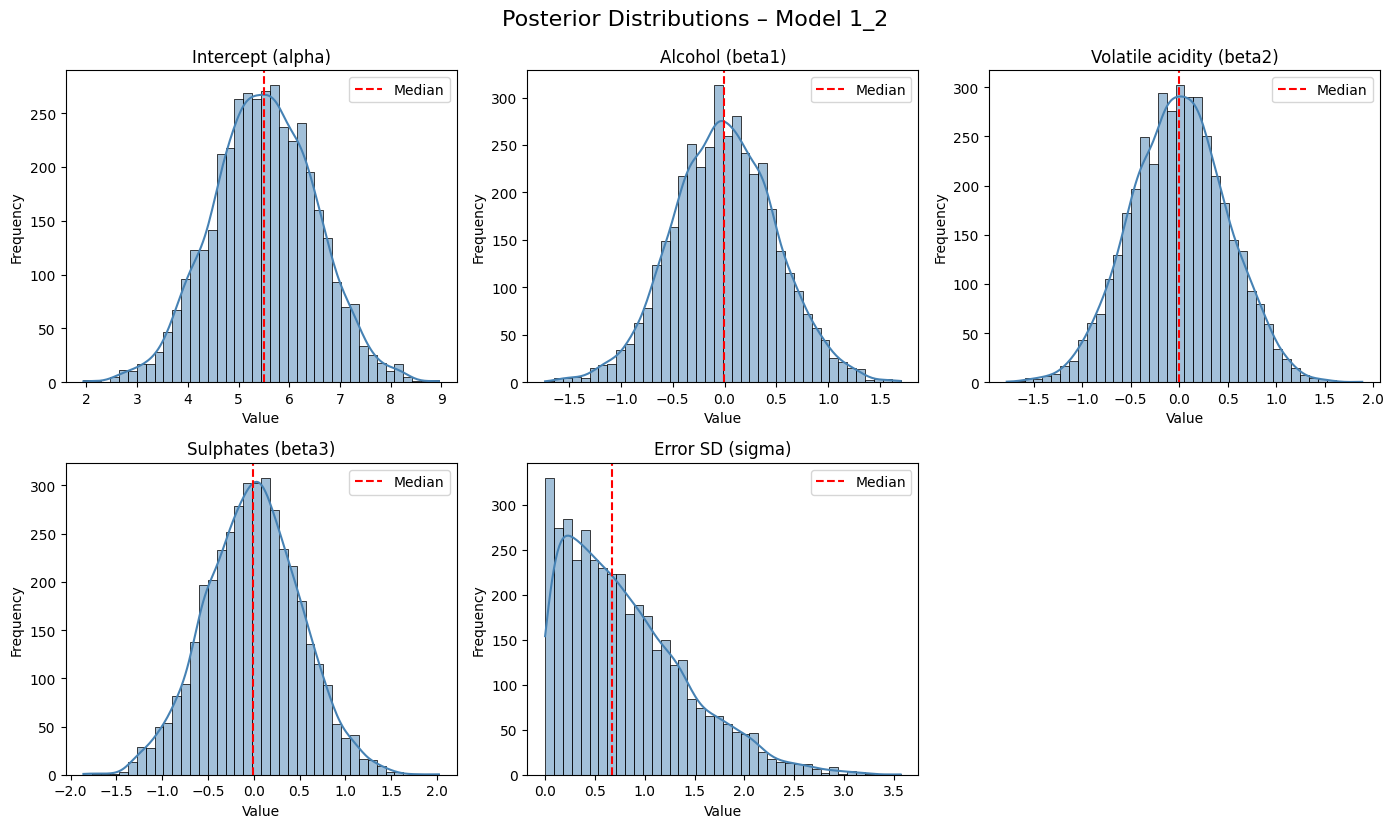

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pobranie danych posteriorów jako DataFrame
posterior_df = fit.draws_pd()

# Lista parametrów do wizualizacji
param_names = ['alpha', 'beta[1]', 'beta[2]', 'beta[3]', 'sigma']
param_labels = {
    'alpha': 'Intercept (alpha)',
    'beta[1]': 'Alcohol (beta1)',
    'beta[2]': 'Volatile acidity (beta2)',
    'beta[3]': 'Sulphates (beta3)',
    'sigma': 'Error SD (sigma)'
}

# Tworzenie wykresów
plt.figure(figsize=(14, 8))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 3, i)
    sns.histplot(posterior_df[param], bins=40, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels[param])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 1_2", fontsize=16, y=1.03)
plt.show()

The posterior distributions for Model 1.2 indicate that alcohol content has the strongest positive association with wine quality, while volatile acidity appears to slightly reduce it. Sulphates have a weak positive effect, but the posterior is still close to zero, suggesting limited evidence for strong influence. The posterior for sigma shows a low residual variance, indicating that the model fits the data fairly well.

**Posterior predictive check - model 1_2**

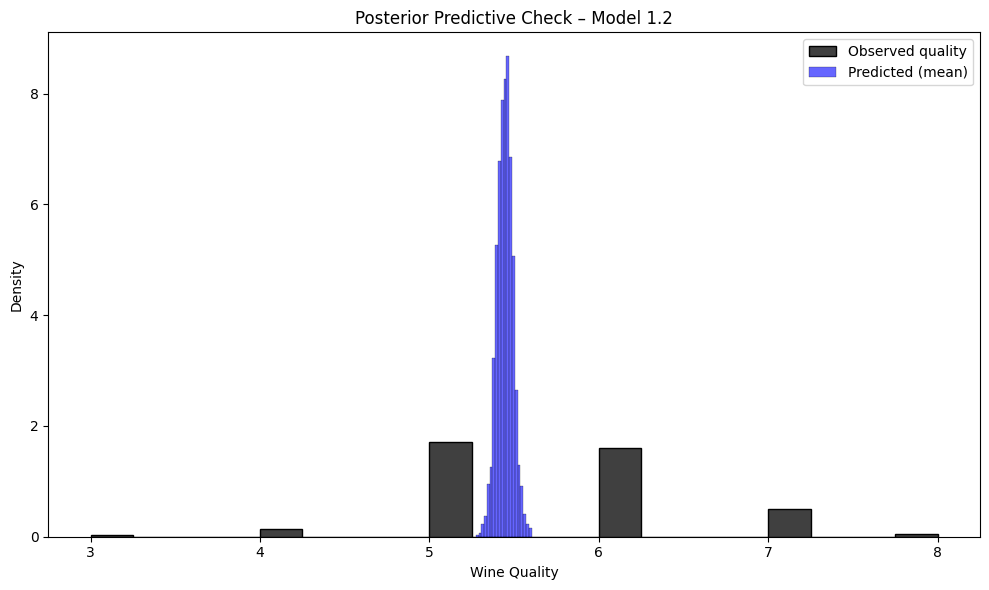

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Wyciąganie próbek z posteriora
posterior_df = fit.draws_pd()
alpha_samples = posterior_df["alpha"].values
beta_samples = posterior_df[["beta[1]", "beta[2]", "beta[3]"]].values
sigma_samples = posterior_df["sigma"].values

# Użyj np. 500 losowych próbek do predykcji
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_selected @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Konwersja do tablicy: (n_draws x n_observations)
y_pred_samples = np.array(y_pred_samples)

# PPC: rozkład danych obserwowanych vs. predykowanych
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=20, color="black", label="Observed quality", stat="density")
sns.histplot(y_pred_samples.mean(axis=0), bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density")

plt.title("Posterior Predictive Check – Model 1_2")
plt.xlabel("Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


While the model captured the central tendency of wine quality well, the posterior predictive check revealed that the predicted values are overly concentrated and do not reflect the actual spread of the data. This suggests underfitting or a lack of sufficient explanatory variables. A second model will be introduced to address this issue.

To improve flexibility of model, the new version was created: *model1_3.stan*.

In [35]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_3.stan")

fit = model.sample(
    data=stan_data,  # przygotowana wcześniej struktura
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

13:09:07 - cmdstanpy - INFO - compiling stan file /workspace/projekt/models/model1_3.stan to exe file /workspace/projekt/models/model1_3
13:10:11 - cmdstanpy - INFO - compiled model executable: /workspace/projekt/models/model1_3
13:10:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:10:14 - cmdstanpy - INFO - CmdStan done processing.
13:10:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model1_3.stan', line 21, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -133.332000  0.035803  1.577700  1.392900 -136.346000 -133.007000   
alpha      5.635800  0.000249  0.016785  0.016924    5.608470    5.635860   
beta[1]    0.329307  0.000242  0.016522  0.016521    0.302610    0.329357   
beta[2]   -0.218704  0.000262  0.017657  0.017896   -0.247476   -0.218859   
beta[3]    0.115161  0.000249  0.016960  0.016541    0.087323    0.115346   
sigma      0.659352  0.000168  0.011407  0.011644    0.640853    0.659279   

                95%  ESS_bulk  ESS_tail    R_hat  
lp__    -131.455000   1956.32   2854.02  1.00115  
alpha      5.663510   4687.42   2928.61  1.00004  
beta[1]    0.356446   4659.03   3354.79  1.00077  
beta[2]   -0.189951   4591.20   3214.12  0.99966  
beta[3]    0.142711   4714.18   3214.58  1.00274  
sigma      0.678014   4684.79   3342.07  1.00061  


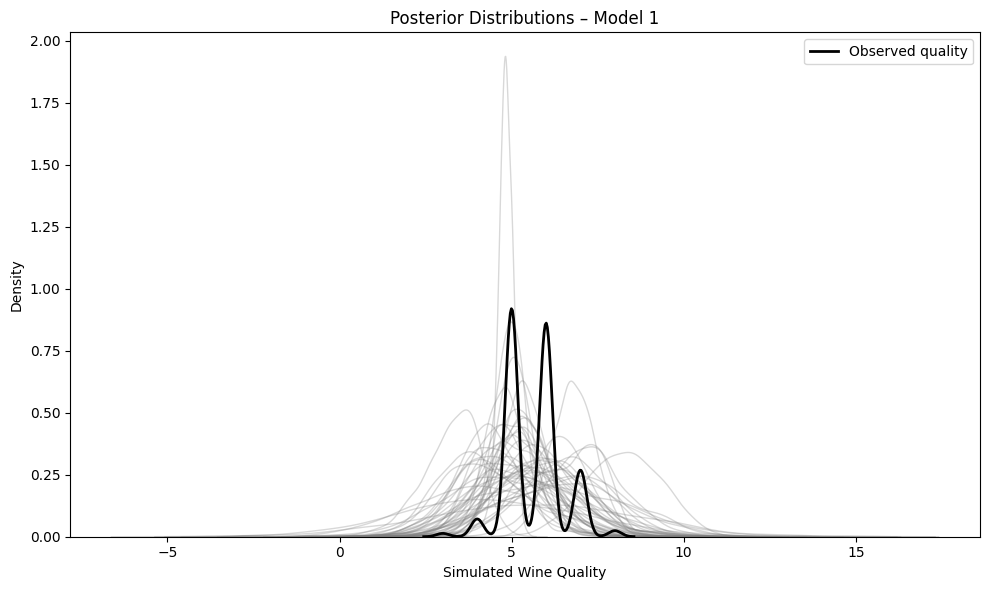

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia
n_samples = 500  # ile razy losujemy alpha, beta, sigma
n_obs = X_scaled_selected.shape[0]  # liczba obserwacji

# Wygeneruj próbki z PRIÓRÓW
alpha_prior = np.random.normal(loc=5.5, scale=1.0, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=0.5, size=(n_samples, 3))
sigma_prior = np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_samples))  # T[0,]

# Prior predictive simulations
y_prior_samples = []

for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Konwersja
y_prior_samples = np.array(y_prior_samples)

# Wykres – kilka przykładowych krzywych
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1)

# Rzeczywisty rozkład jakości dla porównania
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Posterior Distributions – Model 1_3")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

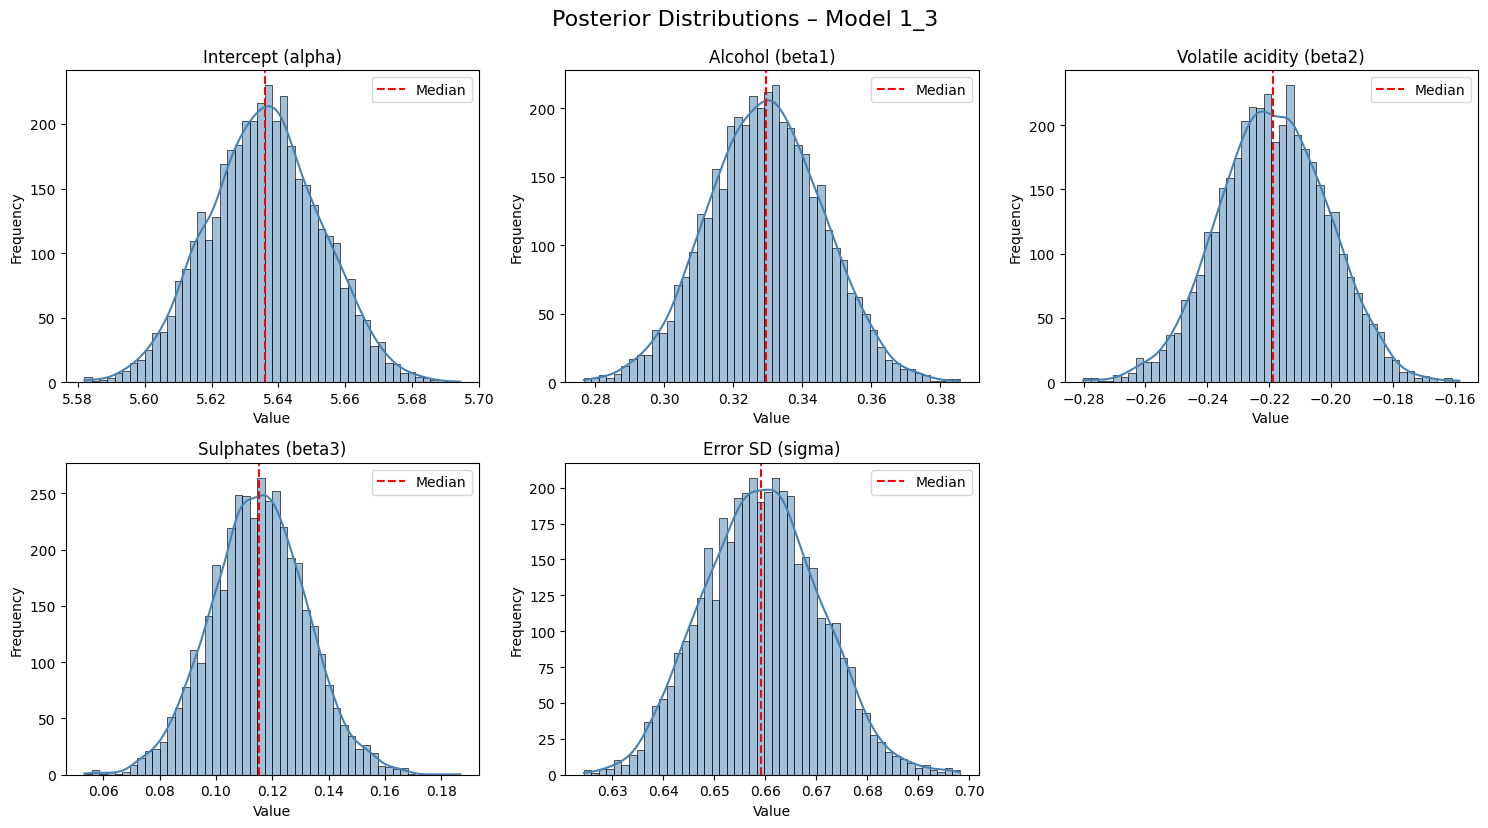

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Zakładamy, że fit to wynik modelu 1_3
posterior_df = fit.draws_pd()

# Lista parametrów, dopasowana do obecnego modelu
param_names = [col for col in posterior_df.columns if col.startswith("alpha") or col.startswith("beta") or col == "sigma"]

# Przyjazne nazwy do wykresów
param_labels = {
    "alpha": "Intercept (alpha)",
    "beta[1]": "Alcohol (beta1)",
    "beta[2]": "Volatile acidity (beta2)",
    "beta[3]": "Sulphates (beta3)",
    "sigma": "Error SD (sigma)"
}

# Tworzenie wykresów
plt.figure(figsize=(15, 8))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 3, i)
    sns.histplot(posterior_df[param], bins=50, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels.get(param, param))  # fallback jeśli czegoś brakuje
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 1_3", fontsize=16, y=1.03)
plt.show()


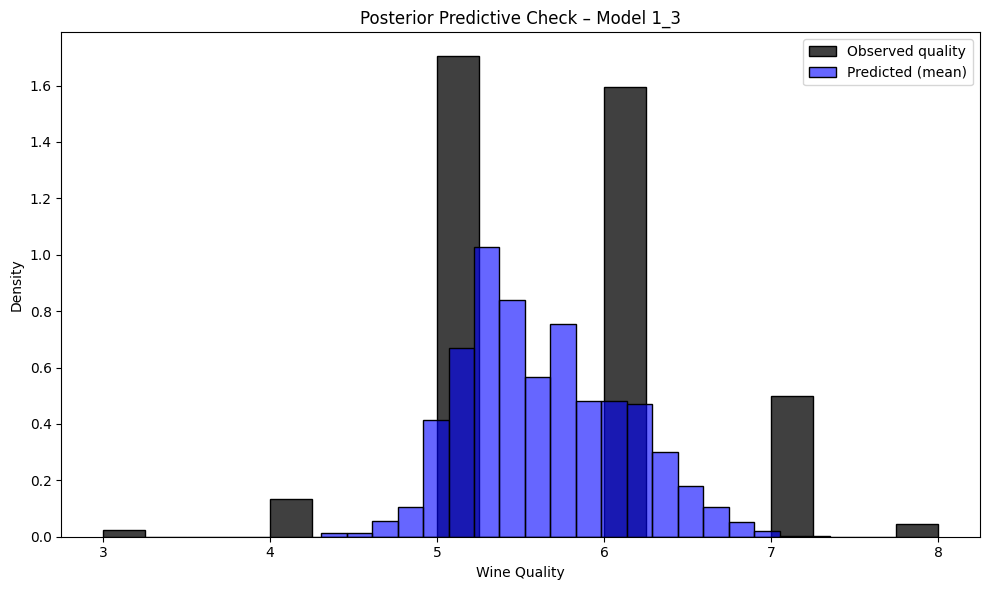

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Wyciąganie próbek z posteriora
posterior_df = fit.draws_pd()
alpha_samples = posterior_df["alpha"].values
beta_samples = posterior_df[["beta[1]", "beta[2]", "beta[3]"]].values
sigma_samples = posterior_df["sigma"].values

# Użyj np. 500 losowych próbek do predykcji
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_selected @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Konwersja do tablicy: (n_draws x n_observations)
y_pred_samples = np.array(y_pred_samples)

# PPC: rozkład danych obserwowanych vs. predykowanych
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=20, color="black", label="Observed quality", stat="density")
sns.histplot(y_pred_samples.mean(axis=0), bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density")

plt.title("Posterior Predictive Check – Model 1_3")
plt.xlabel("Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


The revised Model 1.3 with more flexible priors better reflects the observed variability in wine quality. The posterior predictive distribution is now wider and more aligned with the empirical distribution. However, the model still underestimates the tails, indicating that additional explanatory variables may be required — this will be addressed in Model 2.

To be done now: creation of Model 2 (probably 2_1, 2_2 ...) with predictors:alcohol, volatile acidity, sulphates, citric acid and density.


**Model 2**